In [83]:
!pip install fastapi nest-asyncio pyngrok uvicorn
!pip install gradio

In [84]:
import os
import shutil
from glob import glob


import pandas as pd
import numpy as np

 
import cv2
from PIL import Image
import matplotlib.image as mpimg


import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models


from sklearn.metrics import classification_report, confusion_matrix


In [85]:
BASE_DIR = '/kaggle/input/pcos-detection-using-ultrasound-images'
WORKING_DIR = '/kaggle/working'


original_data_path = os.path.join(BASE_DIR, 'data')
working_data_path = os.path.join(WORKING_DIR, 'data')

In [86]:

train_path = '/kaggle/input/pcos-detection-using-ultrasound-images/data/train'
test_path = '/kaggle/input/pcos-detection-using-ultrasound-images/data/test'


def count_images(path):
    infected = len(os.listdir(os.path.join(path, 'infected')))
    notinfected = len(os.listdir(os.path.join(path, 'notinfected')))
    return infected, notinfected

train_infected, train_notinfected = count_images(train_path)
test_infected, test_notinfected = count_images(test_path)

print(f"Training Set: {train_infected} infected, {train_notinfected} not infected")
print(f"Test Set: {test_infected} infected, {test_notinfected} not infected")


Training Set: 781 infected, 1143 not infected
Test Set: 787 infected, 1145 not infected


Infected Samples:


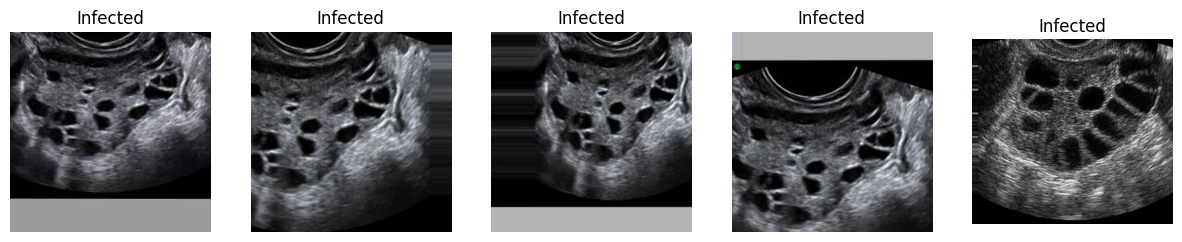

Not Infected Samples:


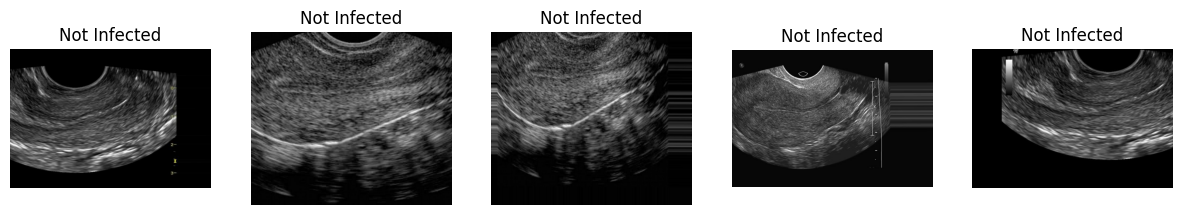

In [87]:
def show_images(folder, label, num=5):
    files = glob(os.path.join(folder, '*.*'))[:num]  
    if len(files) == 0:
        print(f"No images found in: {folder}")
        return
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        img = mpimg.imread(file)
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()


print("Infected Samples:")
show_images(os.path.join(train_path, 'infected'), 'Infected')

print("Not Infected Samples:")
show_images(os.path.join(train_path, 'notinfected'), 'Not Infected')


In [88]:
shutil.copytree(original_data_path, working_data_path, dirs_exist_ok=True)

'/kaggle/working/data'

In [89]:
def find_corrupted_images(directory):
    corrupted = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(subdir, file)
            try:
                img = Image.open(path)
                img.verify()
            except Exception:
                corrupted.append(path)
    return corrupted

corrupted_imgs = find_corrupted_images(working_data_path)
for path in corrupted_imgs:
    try:
        os.remove(path)
    except:
        print(f"{path} has not been deleted (probably system read-only)")

In [90]:
img_height, img_width = 128, 128
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(working_data_path, 'train')
test_dir = os.path.join(working_data_path, 'test')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1924 images belonging to 2 classes.
Found 1922 images belonging to 2 classes.


In [91]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

In [92]:
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 626ms/step - accuracy: 0.7658 - loss: 0.4990 - val_accuracy: 0.9995 - val_loss: 0.0031
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 39s 635ms/step - accuracy: 0.9975 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 623ms/step - accuracy: 1.0000 - loss: 7.3258e-04 - val_accuracy: 1.0000 - val_loss: 1.2641e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 627ms/step - accuracy: 1.0000 - loss: 1.1831e-04 - val_accuracy: 1.0000 - val_loss: 5.6781e-05
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 621ms/step - accuracy: 1.0000 - loss: 5.8795e-05 - val_accuracy: 1.0000 - val_loss: 3.8645e-05
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 621ms/step - accuracy: 1.0000 - loss: 3.6194e-05 - val_accuracy: 1.0000 - val_loss: 2.9312e-05
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 624ms/step - accuracy: 1.0000 - loss: 2.8020e-05 - val_accuracy: 1.0000 - val_loss: 2.2408e-05
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 622ms/step - ac

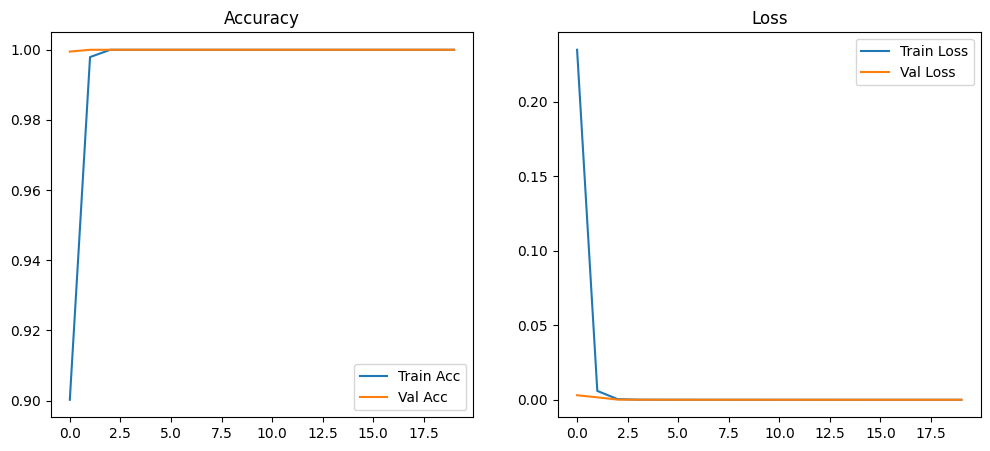

In [94]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [95]:

best_train_acc = max(history.history['accuracy'])
best_val_acc = max(history.history['val_accuracy'])


min_train_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])


print(f"🔹 Best Training Accuracy: {best_train_acc:.4f}")
print(f"🔹 Best Validation Accuracy: {best_val_acc:.4f}")
print(f"🔸 Lowest Training Loss: {min_train_loss:.4f}")
print(f"🔸 Lowest Validation Loss: {min_val_loss:.4f}")


🔹 Best Training Accuracy: 1.0000
🔹 Best Validation Accuracy: 1.0000
🔸 Lowest Training Loss: 0.0000
🔸 Lowest Validation Loss: 0.0000


In [104]:
model.save('/kaggle/working/pcos_model.h5')

In [105]:
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/pcos_model.h5')

In [106]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('/kaggle/working/pcos_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpabeaxnug'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132449348075600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449348077904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449348080400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449348078288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132448537673552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449348080016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449348081552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449348079248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449348083088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132448028886992: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1753901314.669274      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753901314.669316      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


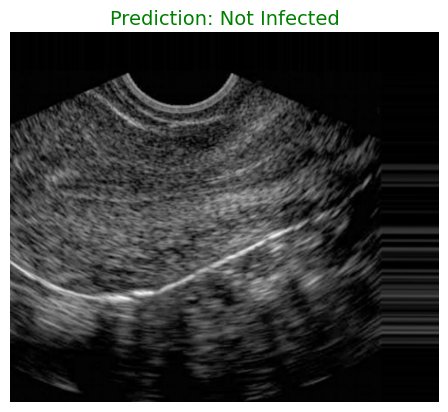

In [119]:
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/pcos_model.tflite')
interpreter.allocate_tensors()


input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


img_path = '/kaggle/working/data/test/notinfected/img_0_0.jpg'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

img_resized = cv2.resize(img, (img_width, img_height))
img_input = img_resized.astype('float32') / 255.0
img_input = np.expand_dims(img_input, axis=0)


interpreter.set_tensor(input_details[0]['index'], img_input)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])


prediction = (output[0][0] > 0.5)
label = "Not Infected" if prediction else "Infected"
color = 'green' if prediction else 'red'


plt.imshow(img_rgb)
plt.title(f"Prediction: {label}", color=color, fontsize=14)
plt.axis('off')
plt.show()
